In [1]:
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

from PIL import Image
from tools import analytics
from core.tops.config.instantiate import instantiate
import torchvision
import torch
import numpy as np
from matplotlib import pyplot as plt

from core.tops import torch_utils

from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.ablation_layer import AblationLayer
from collections import OrderedDict
import cv2
import numpy as np
from vizer.draw import draw_boxes

from scripts.save_comparison_images import convert_image_to_hwc_byte, create_comparison_image
from scripts.save_comparison_images import get_config, get_trained_model, get_dataloader, create_prediction_image


import requests

from core.tops.torch_utils import get_device, to_cuda
from scripts.save_comparison_images import convert_boxes_coords_to_pixel_coords

In [2]:
CFG_PATH = "core/configs/task4/retina_P4_retrain_overfit.py"

cfg = get_config(CFG_PATH)

dataloader = get_dataloader(cfg, "val")

image_url1 = "datasets/tdt4265_overfit/images/train/trip007_glos_Video00000_10.png"
image1 = np.array(Image.open(image_url1))
image_float_np1 = np.float32(image1) / 255

transform1 = instantiate(cfg.data_val.gpu_transform)


dataloader = iter(dataloader)

model1 = get_trained_model(cfg)

Loading config from: core/configs/task4/retina_P4_retrain_overfit.py
--------------------------------------------------------------------------------


2022-04-28 16:16:03,123 [INFO ] Loaded checkpoint from outputs/configs/task4/retina_P4_retrain_overfit/checkpoints/4019.ckpt


In [3]:
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

def pro_predict(input_tensor, model, detection_threshold):
    boxes, categories, scores = model(input_tensor, score_threshold=detection_threshold)[0]
    boxes = convert_boxes_coords_to_pixel_coords(boxes.detach().cpu(), batch["width"], batch["height"])
    categories = categories.cpu().numpy().tolist()
    return boxes, categories, scores

def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def retinafpn_reshape_transform(features: tuple):
    target_size = (1, 8) # select one bigger maybe later
    activations = []
    for feat in features:
        activations.append(torch.nn.functional.interpolate(torch.abs(feat), target_size))
    activations = torch.cat(activations, axis=1)
    return activations

In [4]:
batch = next(dataloader)

score_threshold = 0.99

canvas_image = convert_image_to_hwc_byte(batch["image"])

pred_image = to_cuda(batch["image"])
transformed_image = transform1({"image": pred_image})["image"]

boxes, labels, scores = pro_predict(transformed_image, model1, score_threshold)

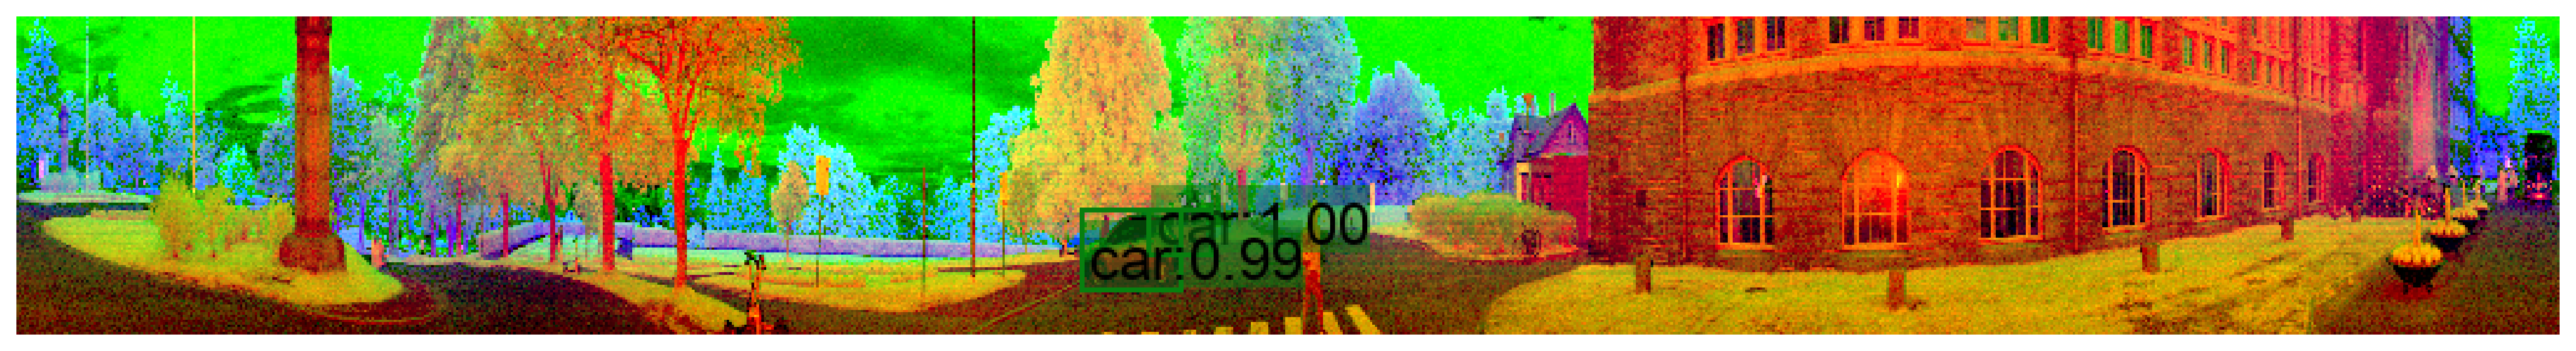

In [5]:
image = draw_boxes(canvas_image, boxes, labels, scores, class_name_map=cfg.label_map)

plt.figure(figsize=(10, 10), dpi=600)
plt.axis("off")
plt.imshow(image)

In [6]:
# image_url2 = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# image2 = np.array(Image.open(requests.get(image_url2, stream=True).raw))
# image_float_np2 = np.float32(image2) / 255

# # define the torchvision image transforms
# transform2 = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
# ])

# input_tensor2 = transform2(image2)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# input_tensor2 = input_tensor2.to(device)

# # Add a batch dimension:
# input_tensor2 = input_tensor2.unsqueeze(0)

# model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model2.eval().to(device);

# # Run the model and display the detections
# bboxes2, classes2, labels2, indices2 = predict(input_tensor2, model2, device, 0.9)


In [7]:
# print(bboxes2, classes2, labels2, indices2)

In [8]:
class RetinaNetBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
        assign a score on how the current bounding boxes match it,
            1. In IOU
            2. In the classification score.
        If there is not a large enough overlap, or the category changed,
        assign a score of 0.

        The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold
        self.box_idx = 0
        self.lbl_idx = 1
        self.scr_idx = 2

    def convert_boxes(self, torch_boxes, width: int = 1024, height: int = 128):
        torch_boxes[:, [0, 2]] *= width
        torch_boxes[:, [1, 3]] *= height
        return torch_boxes

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()
        if len(model_outputs[self.box_idx]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, self.convert_boxes(model_outputs[self.box_idx]))
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs[self.lbl_idx][index] == label:
                score = ious[0, index] + model_outputs[self.scr_idx][index]
                output = output + score
        return output

In [9]:
from collections import OrderedDict

class RetinaNetModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super().__init__()
        self.model = model

    def forward(self, x):
        boxes, categories, scores = self.model(x)[0]
        od = OrderedDict()
        od["boxes"] = boxes
        od["labels"] = categories
        od["scores"] = scores

        print("returning > ", od)
        return od
        # get the original model output by feeding it x
        # convert the original model output (from init) into a dict

In [10]:
for f in model1.feature_extractor(torch.randn(1, 3, 128, 1024).cuda()): print(f.shape)

torch.Size([1, 256, 32, 256])
torch.Size([1, 256, 16, 128])
torch.Size([1, 256, 8, 64])
torch.Size([1, 256, 4, 32])
torch.Size([1, 256, 2, 16])
torch.Size([1, 256, 1, 8])


In [11]:
my_classes = [cfg.label_map[idx] for idx in labels]; my_classes

['car', 'car']

In [12]:
labels

[1, 1]

In [13]:
boxes

array([[455.50266,  77.47219, 481.8378 ,  96.36228],
       [428.94473,  77.86969, 469.5961 , 110.08832]], dtype=float32)

returning >  OrderedDict([('boxes', tensor([[0.4448, 0.6053, 0.4705, 0.7528],
        [0.4189, 0.6084, 0.4586, 0.8601],
        [0.5883, 0.6462, 0.6017, 0.7919],
        [0.2888, 0.7349, 0.3013, 0.9994],
        [0.5037, 0.5746, 0.5147, 1.0030],
        [0.2807, 0.7426, 0.2917, 0.9980],
        [0.1408, 0.6812, 0.1448, 0.7914],
        [0.1378, 0.6772, 0.1418, 0.7915],
        [0.5231, 0.5859, 0.5290, 0.6891],
        [0.5417, 0.5729, 0.5578, 0.6585]], device='cuda:0',
       grad_fn=<IndexBackward0>)), ('labels', tensor([1, 1, 5, 6, 7, 6, 7, 7, 7, 1], device='cuda:0')), ('scores', tensor([0.9963, 0.9920, 0.9868, 0.9642, 0.9277, 0.9118, 0.8496, 0.8401, 0.6741,
        0.5742], device='cuda:0', grad_fn=<IndexBackward0>))])
outputs: OrderedDict([('boxes', tensor([[0.4448, 0.6053, 0.4705, 0.7528],
        [0.4189, 0.6084, 0.4586, 0.8601],
        [0.5883, 0.6462, 0.6017, 0.7919],
        [0.2888, 0.7349, 0.3013, 0.9994],
        [0.5037, 0.5746, 0.5147, 1.0030],
        [0.2807, 0.7426, 0

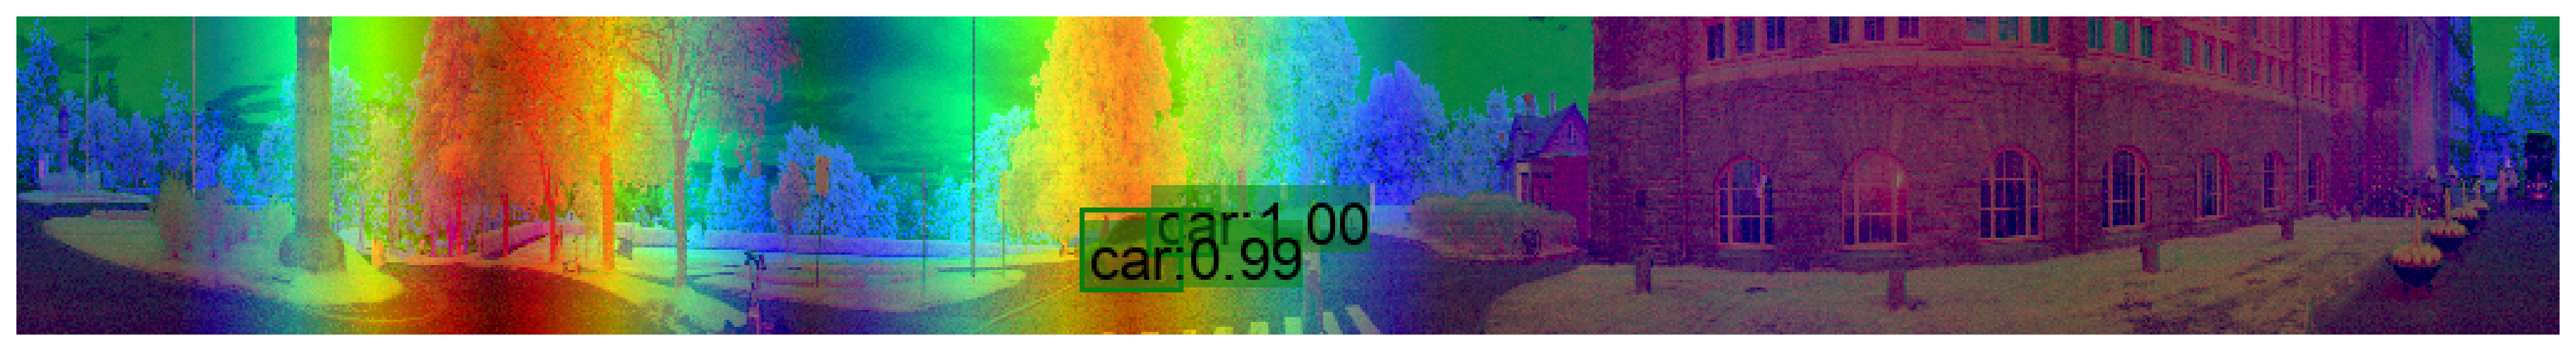

In [14]:
target_layers = [model1.feature_extractor]

targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]

use_model = RetinaNetModelOutputWrapper(model1)

cam = EigenCAM(
    use_model,
    target_layers, 
    use_cuda=torch.cuda.is_available(),
    reshape_transform=retinafpn_reshape_transform
)

grayscale_cam = cam(transformed_image, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]

canvas_image = np.float32(canvas_image) / 255

cam_image = show_cam_on_image(canvas_image, grayscale_cam, use_rgb=True)

# And lets draw the boxes again:
# image_with_bounding_boxes = draw_boxes(boxes, labels, my_classes, cam_image)
# image_with_bounding_boxes = draw_boxes(boxes, labels, my_classes, cam_image)
image_with_bounding_boxes = draw_boxes(cam_image, boxes, labels, scores, class_name_map=cfg.label_map)

plt.figure(figsize=(10, 10), dpi=600)
plt.axis("off")
plt.imshow(image_with_bounding_boxes, cmap="gray")

In [15]:
for x1, y1, x2, y2 in boxes:
    print(x1, y1, x2, y2)

455.50266 77.47219 481.8378 96.36228
428.94473 77.86969 469.5961 110.08832


In [16]:
grayscale_cam.shape

(128, 1024)

In [17]:
def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    for x1, y1, x2, y2 in boxes:
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        img = renormalized_cam * 0
        img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
        images.append(img)
    
    renormalized_cam = np.max(np.float32(images), axis = 0)
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    # image_with_bounding_boxes = draw_boxes(boxes, labels, my_classes, eigencam_image_renormalized)
    image_with_bounding_boxes = draw_boxes(eigencam_image_renormalized, boxes, labels, scores, class_name_map=cfg.label_map)

    return image_with_bounding_boxes

renom_image = renormalize_cam_in_bounding_boxes(boxes, canvas_image, grayscale_cam)

ValueError: margin must be greater than -0.5

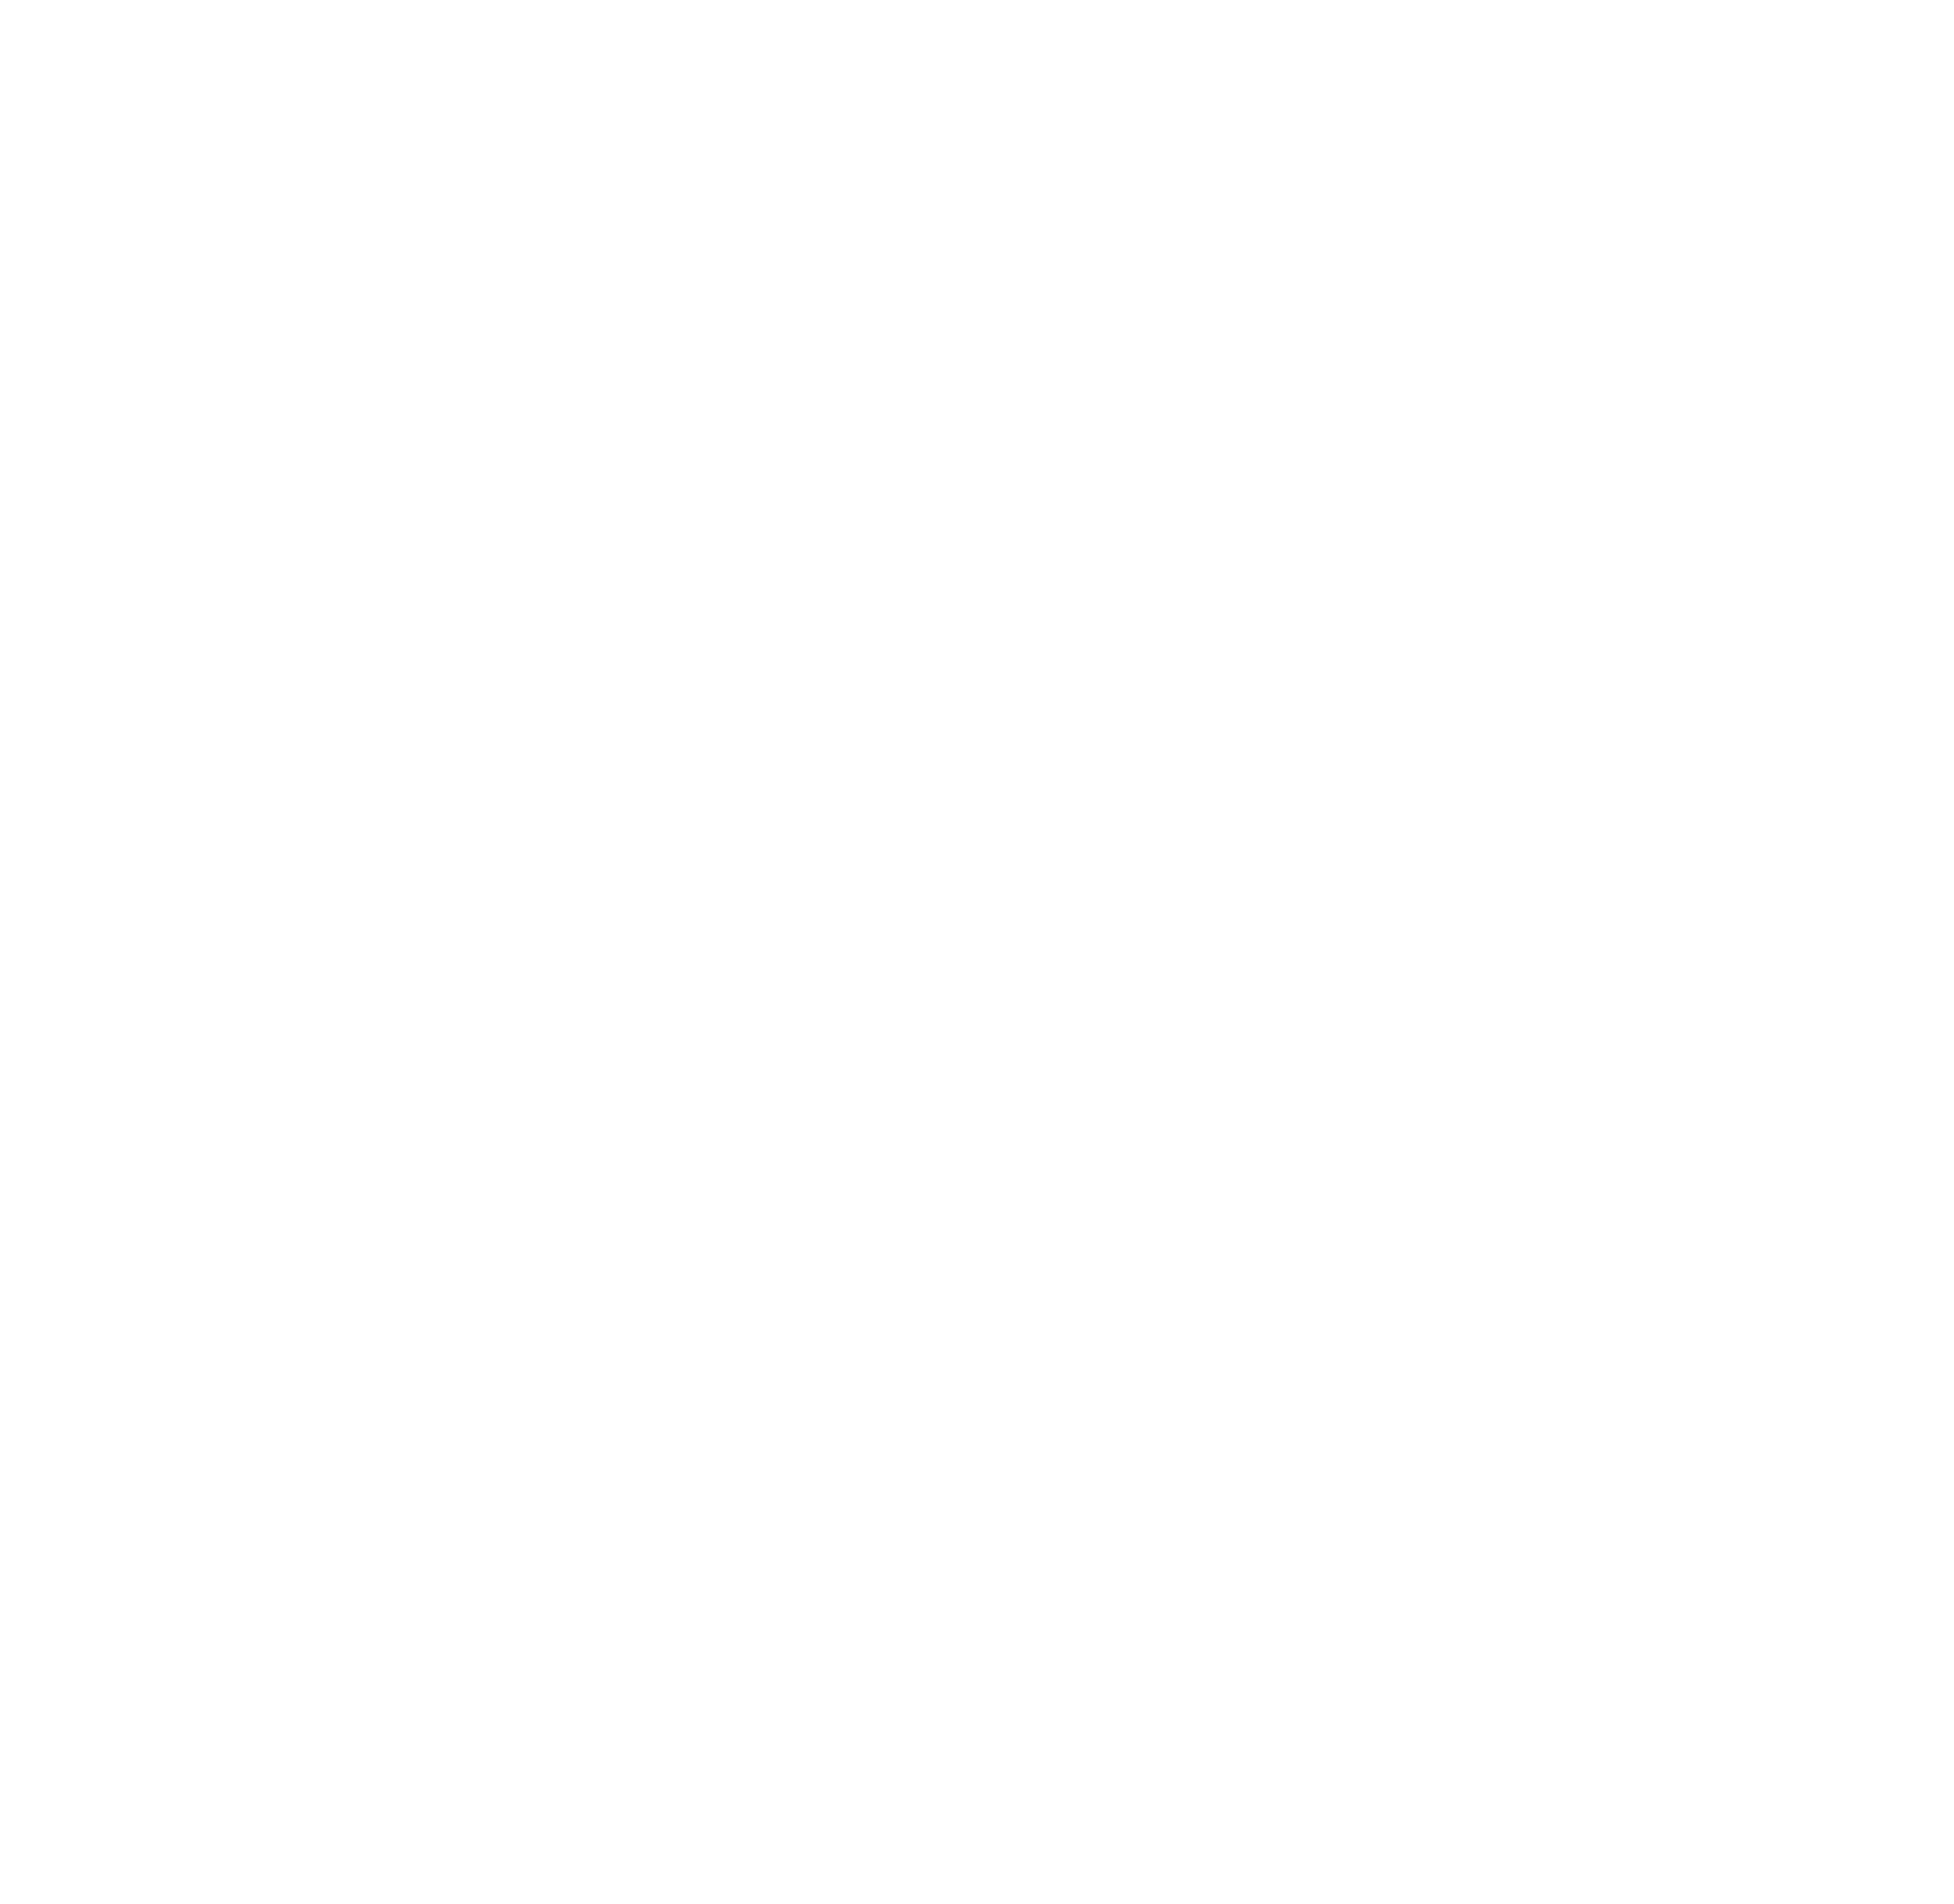

In [18]:
plt.figure(figsize=(10, 10), dpi=600)
plt.axis("off")
plt.xlim(512-50, 512+50)
plt.imshow(renom_image)